# *Robust Recognition of Music-induced emotion via GESSNet and Audio Feature Fusion* - Code to reproduce results

## **Install & import libraries**

In [3]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 85.4 MB/s eta 0:00:00


## **GESSNet + OpenSMILE**

In [5]:
import pandas as pd

OPENSMILE_CSV = "OpenSMILE_features.csv"
song_features_df = pd.read_csv(OPENSMILE_CSV, index_col="song_id")
song_feature_dict = song_features_df.to_dict(orient="index")

Selected 984 features out of 988 based on variance
Number of classes: 4
Classes: [0 1 2 3]
Train records: 223
Val records: 71

Starting comprehensive Fixed Split analysis...

Starting Fixed Split Analysis with 5 runs
Device: cuda
Train records: 223, Val records: 71


Loading EEG NPY: 100%|██████████| 71/71 [00:00<00:00, 125.34it/s]


Actual Train dataset size: 222
Actual Val dataset size: 71

--- Training Run 1/5 ---
Train samples: 222, Val samples: 71
  Epoch  1: Train Loss: 1.5480, Val Loss: 1.3884, Val Acc: 0.2535
  Epoch 11: Train Loss: 0.4896, Val Loss: 2.0437, Val Acc: 0.3803
  Early stopping at epoch 16
  Run 1 Results: Train Acc: 0.9505, Val Acc: 0.4225

--- Training Run 2/5 ---
Train samples: 222, Val samples: 71
  Epoch  1: Train Loss: 1.5166, Val Loss: 1.3897, Val Acc: 0.2676
  Epoch 11: Train Loss: 0.4316, Val Loss: 2.2701, Val Acc: 0.3380
  Early stopping at epoch 16
  Run 2 Results: Train Acc: 0.9459, Val Acc: 0.4366

--- Training Run 3/5 ---
Train samples: 222, Val samples: 71
  Epoch  1: Train Loss: 1.5360, Val Loss: 1.3853, Val Acc: 0.2535
  Epoch 11: Train Loss: 0.4554, Val Loss: 2.0895, Val Acc: 0.3803
  Early stopping at epoch 20
  Run 3 Results: Train Acc: 0.9505, Val Acc: 0.4930

--- Training Run 4/5 ---
Train samples: 222, Val samples: 71
  Epoch  1: Train Loss: 1.5185, Val Loss: 1.3997, Val 

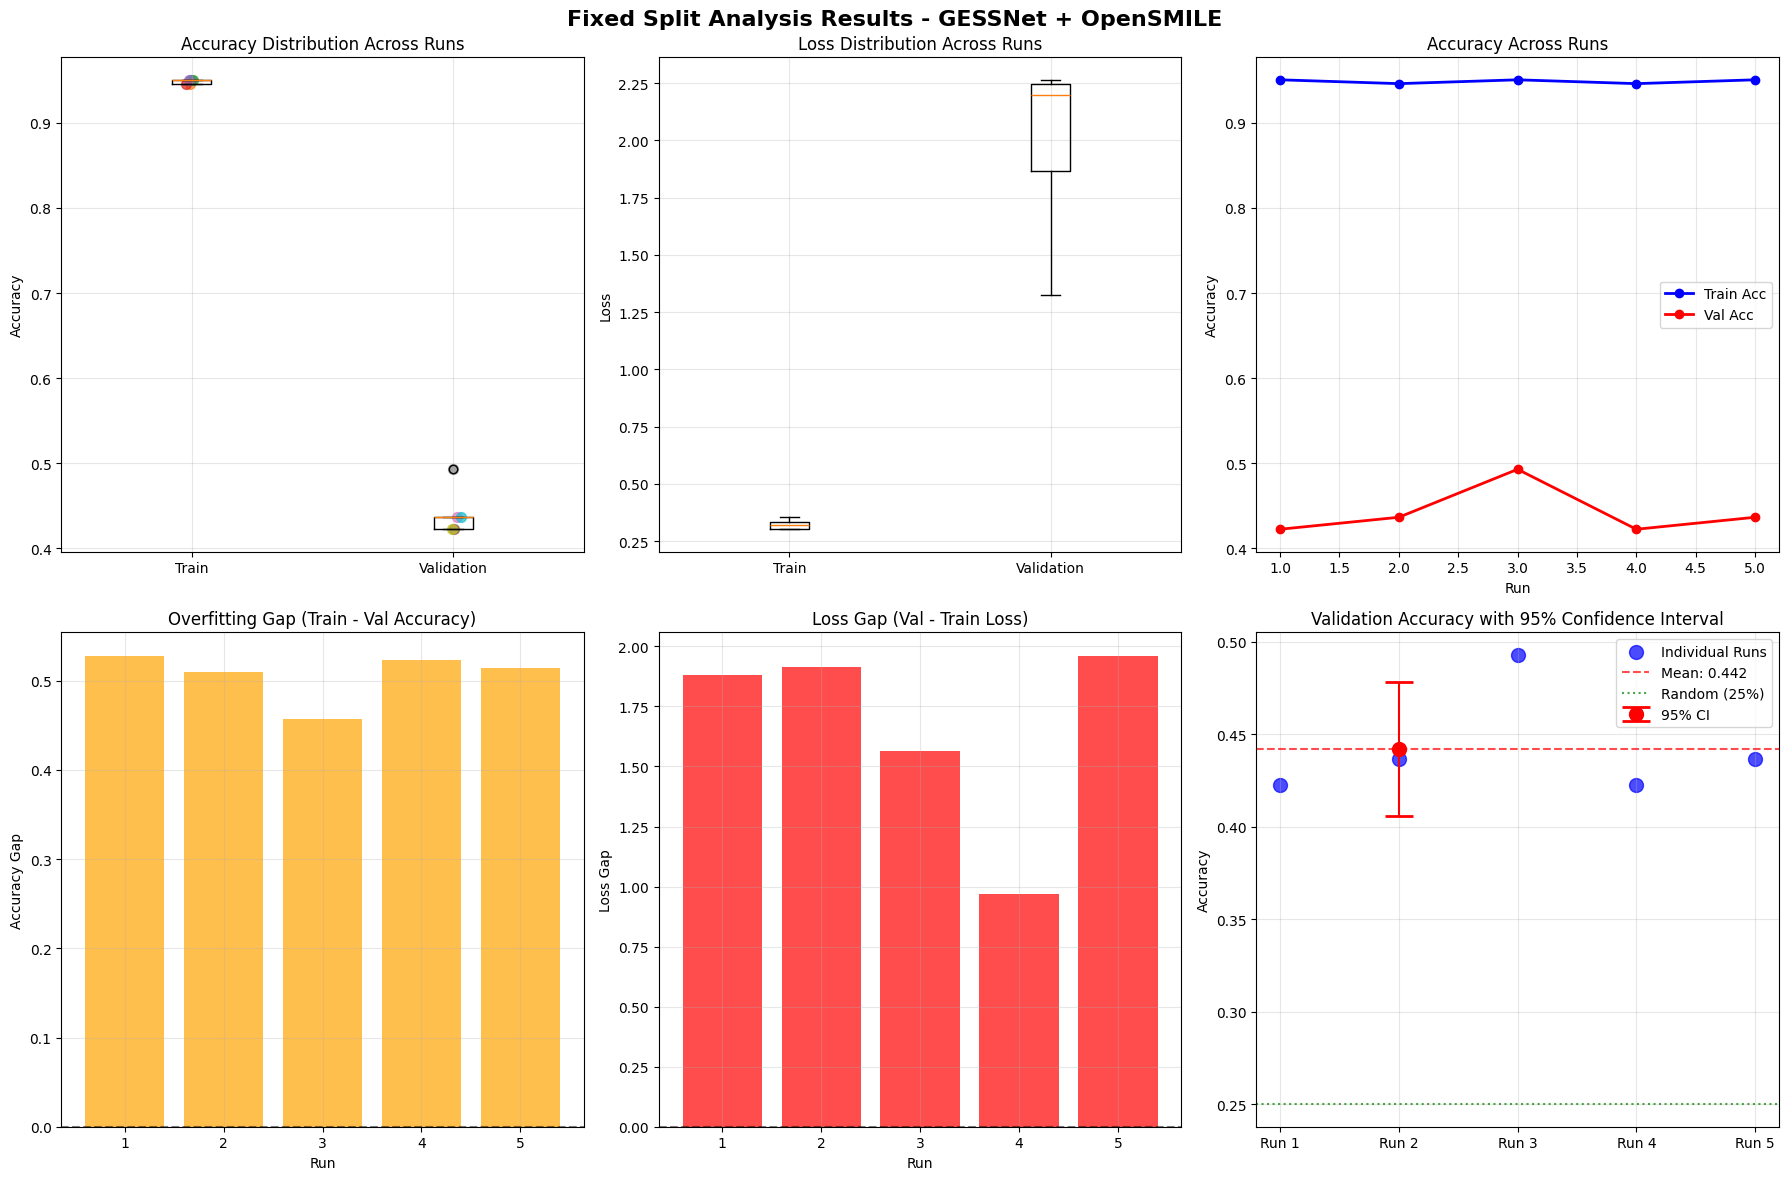


COMPREHENSIVE GESSNet + OpenSMILE MODEL PERFORMANCE REPORT (FIXED SPLIT)

PERFORMANCE SUMMARY:
  Validation Accuracy:     0.4423 ± 0.0292 (44.2% ± 2.9%)
  95% Confidence Interval: [0.4060, 0.4785]
  Coefficient of Variation: 6.60%
  Best Single Run:        0.4930
  Worst Single Run:       0.4225
  Performance Range:       ±0.0352

  Training Accuracy:       0.9486 ± 0.0025 (94.9% ± 0.2%)
  Accuracy Gap (Train-Val): 0.5064 (50.6%)
  GESSNet + OpenSMILE: 44.2% ± 2.9% (CV: 6.6%)
Model Variance Analysis:
  • GESSNet + OpenSMILE model achieves 44.2% ± 2.9% accuracy
  • Coefficient of Variation: 6.6%


In [8]:
from sklearn.preprocessing import StandardScaler


# === HYPERPARAMETERS ===
BATCH_SIZE = 32
EPOCHS = 60
LR = 2e-3
PATIENCE = 8
WARMUP_EPOCHS = 5
MIN_LR = 1e-6
DROPOUT_RATE = 0.3
WEIGHT_DECAY = 5e-5

# Analysis Parameters
N_RUNS = 5  # Number of runs with different random seeds
RANDOM_STATE = 42

# Set seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# === Statistical Analysis Functions ===
def calculate_confidence_interval(data, confidence=0.95):
    """Calculate confidence interval for a dataset"""
    n = len(data)
    if n < 2:
        return np.mean(data), 0, 0

    mean = np.mean(data)
    std = np.std(data, ddof=1)
    se = std / np.sqrt(n)

    # Using t-distribution for small samples
    from scipy import stats
    t_val = stats.t.ppf((1 + confidence) / 2, n - 1)
    margin_error = t_val * se

    return mean, mean - margin_error, mean + margin_error

def analyze_model_stability(results_dict):
    # Extract metrics
    train_accs = results_dict['train_accuracies']
    val_accs = results_dict['val_accuracies']
    train_losses = results_dict['train_losses']
    val_losses = results_dict['val_losses']

    # Calculate statistics
    stats_data = {}
    for name, data in [('Train Acc', train_accs), ('Val Acc', val_accs),
                      ('Train Loss', train_losses), ('Val Loss', val_losses)]:
        mean, ci_low, ci_high = calculate_confidence_interval(data)
        stats_data[name] = {
            'mean': mean,
            'std': np.std(data, ddof=1),
            'cv': np.std(data, ddof=1) / mean if mean != 0 else 0,
            'ci_low': ci_low,
            'ci_high': ci_high,
            'range': np.max(data) - np.min(data),
            'data': data
        }

    return stats_data

# === Load and preprocess OpenSMILE features ===
def load_and_preprocess_features():
    """Load and preprocess OpenSMILE song features"""
    # Load song features
    song_features_df = pd.read_csv(OPENSMILE_CSV, index_col=0)

    # Normalize features
    scaler = StandardScaler()
    song_features_normalized = scaler.fit_transform(song_features_df.values.astype(np.float32))
    song_features_df = pd.DataFrame(song_features_normalized.astype(np.float32),
                                   index=song_features_df.index,
                                   columns=song_features_df.columns)

    # Feature selection based on variance
    feature_variance = song_features_df.var()
    high_variance_features = feature_variance > 0.01
    song_features_df = song_features_df.loc[:, high_variance_features]
    print(f"Selected {song_features_df.shape[1]} features out of {len(feature_variance)} based on variance")

    song_feature_dict = song_features_df.to_dict(orient="index")
    return song_feature_dict

# === Enhanced EEG Dataset ===
class EEGNPYDataset(Dataset):
    def __init__(self, records, label_encoder, data_dir, song_feature_dict, augment=False):
        self.data = []
        self.max_len = 0
        self.data_dir = data_dir
        self.song_feature_dict = song_feature_dict
        self.augment = augment

        # First pass: find max length
        for rec in tqdm(records, desc="Finding max length"):
            path = os.path.join(data_dir, f"{rec['id']}_eeg.npy")
            if os.path.exists(path):
                eeg = np.load(path)
                self.max_len = max(self.max_len, eeg.shape[1])

        # Second pass: load and pad data
        for rec in tqdm(records, desc="Loading EEG NPY"):
            path = os.path.join(data_dir, f"{rec['id']}_eeg.npy")
            if not os.path.exists(path):
                continue
            try:
                eeg = np.load(path)
                eeg = eeg.astype(np.float32)

                # Center the data if long enough
                if eeg.shape[1] > 100:
                    eeg = eeg - np.mean(eeg, axis=1, keepdims=True).astype(np.float32)

                # Pad to max length
                padded = np.zeros((eeg.shape[0], self.max_len), dtype=np.float32)
                padded[:, :eeg.shape[1]] = eeg

                label = label_encoder.transform([rec["label"]])[0]
                song_id = rec["spotify_track_id"]

                # Skip if song features not available
                if song_id not in self.song_feature_dict:
                    continue

                song_feat = np.array(list(self.song_feature_dict[song_id].values()), dtype=np.float32)
                self.data.append((padded, song_feat, label, rec["id"]))
            except Exception as e:
                print(f"Error loading {rec['id']}: {e}")

    def __len__(self):
        return len(self.data)

    def augment_eeg(self, eeg):
        if not self.augment or np.random.random() > 0.5:
            return eeg.astype(np.float32)

        # Gaussian noise augmentation
        if np.random.random() > 0.5:
            noise_factor = 0.02
            noise = np.random.normal(0, noise_factor, eeg.shape).astype(np.float32)
            eeg = eeg.astype(np.float32) + noise

        # Amplitude scaling
        if np.random.random() > 0.5:
            scale_factor = np.random.uniform(0.9, 1.1)
            eeg = (eeg.astype(np.float32) * scale_factor).astype(np.float32)

        return eeg.astype(np.float32)

    def __getitem__(self, idx):
        eeg, song_feat, label, id_ = self.data[idx]
        eeg = self.augment_eeg(eeg)
        return torch.tensor(eeg, dtype=torch.float32), torch.tensor(song_feat, dtype=torch.float32), label, id_

# === Model Architecture ===
class GESSNetWithOpenSMILE(nn.Module):
    def __init__(self, num_classes, input_channels=64, dropout_rate=0.3, song_feature_dim=None):
        super().__init__()

        # EEG processing branch
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 64), padding=0, bias=False),
            nn.BatchNorm2d(16)
        )

        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(input_channels, 1), groups=16, bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(p=dropout_rate)
        )

        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 16), padding=(0, 8), bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(p=dropout_rate)
        )

        self.additional_conv = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(1, 8), padding=(0, 4), bias=False),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.AdaptiveAvgPool2d((1, 16))
        )

        # EEG feature extraction
        self.fc_eeg = nn.Sequential(
            nn.Linear(64 * 1 * 16, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128)
        )

        # Song feature processing with attention
        self.song_attention = nn.Sequential(
            nn.Linear(song_feature_dim, song_feature_dim // 4),
            nn.ReLU(),
            nn.Linear(song_feature_dim // 4, song_feature_dim),
            nn.Sigmoid()
        )

        self.song_project = nn.Sequential(
            nn.Linear(song_feature_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128)
        )

        # Cross-attention between EEG and song features
        self.cross_attention = nn.MultiheadAttention(embed_dim=128, num_heads=8, dropout=dropout_rate, batch_first=True)

        # Final classifier
        self.fc_combined = nn.Sequential(
            nn.Linear(128 + 128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, eeg, song_feat):
        # EEG processing
        x = eeg.unsqueeze(1)  # (B, 1, C, T)
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = self.additional_conv(x)
        x = x.flatten(start_dim=1)
        eeg_features = self.fc_eeg(x)

        # Song feature processing with attention
        song_attention_weights = self.song_attention(song_feat)
        song_feat_attended = song_feat * song_attention_weights
        song_features = self.song_project(song_feat_attended)

        # Cross-attention
        eeg_features_expanded = eeg_features.unsqueeze(1)
        song_features_expanded = song_features.unsqueeze(1)

        attended_eeg, _ = self.cross_attention(eeg_features_expanded, song_features_expanded, song_features_expanded)
        attended_eeg = attended_eeg.squeeze(1)

        # Combine features
        combined = torch.cat([attended_eeg, song_features], dim=1)
        return self.fc_combined(combined)

# === Learning Rate Scheduler ===
class CosineAnnealingWarmup(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_epochs, max_epochs, eta_min=0, last_epoch=-1):
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        self.eta_min = eta_min
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_epochs:
            return [base_lr * (self.last_epoch + 1) / self.warmup_epochs for base_lr in self.base_lrs]
        else:
            progress = (self.last_epoch - self.warmup_epochs) / (self.max_epochs - self.warmup_epochs)
            return [self.eta_min + (base_lr - self.eta_min) * (1 + np.cos(np.pi * progress)) / 2
                    for base_lr in self.base_lrs]

# === Enhanced Evaluation Functions ===
def evaluate_model(model, loader, device, num_classes, criterion=None):
    model.eval()
    trial_predictions, trial_labels = {}, {}
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for eeg, song_feat, y, trial_ids in loader:
            eeg = eeg.to(device, dtype=torch.float32)
            song_feat = song_feat.to(device, dtype=torch.float32)
            y = y.to(device)

            # Normalize EEG data
            mean = eeg.mean(dim=[1, 2], keepdim=True)
            std = eeg.std(dim=[1, 2], keepdim=True).clamp(min=1e-6)
            eeg = ((eeg - mean) / std).clamp(min=-3.0, max=3.0)

            out = model(eeg, song_feat)

            if criterion is not None:
                loss = criterion(out, y)
                total_loss += loss.item()
                num_batches += 1

            preds = torch.argmax(out, dim=1).cpu().numpy()
            labels = y.cpu().numpy()

            for pred, label, tid in zip(preds, labels, trial_ids):
                tid = int(tid)
                trial_predictions.setdefault(tid, []).append(pred)
                trial_labels[tid] = label

    # Aggregate predictions per trial
    final_preds, final_labels = [], []
    for tid in sorted(trial_predictions.keys()):
        pred_counts = Counter(trial_predictions[tid])
        final_pred = pred_counts.most_common(1)[0][0]
        final_preds.append(final_pred)
        final_labels.append(trial_labels[tid])

    accuracy = accuracy_score(final_labels, final_preds)
    avg_loss = total_loss / num_batches if num_batches > 0 else 0

    if criterion is not None:
        return accuracy, avg_loss
    else:
        return accuracy

# === Single Run Training Function ===
def train_single_run(train_dataset, val_dataset, num_classes, song_feature_dict, run_num, device):
    """Train a single model run with different random seed"""

    # Set different seed for each run
    set_seed(RANDOM_STATE + run_num)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # Initialize model
    song_feat_dim = len(list(song_feature_dict.values())[0])
    model = GESSNetWithOpenSMILE(num_classes=num_classes,
                               input_channels=train_dataset[0][0].shape[0],
                               dropout_rate=DROPOUT_RATE,
                               song_feature_dim=song_feat_dim).to(device)

    # Calculate class weights
    train_labels = [train_dataset[i][2] for i in range(len(train_dataset))]
    label_counts = Counter(train_labels)
    total = sum(label_counts.values())

    class_weights = []
    for i in range(num_classes):
        if i in label_counts:
            weight = np.sqrt(total / label_counts[i])
        else:
            weight = 1.0
        class_weights.append(weight)

    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, betas=(0.9, 0.999))
    scheduler = CosineAnnealingWarmup(optimizer, WARMUP_EPOCHS, EPOCHS, eta_min=MIN_LR)

    best_val_acc = 0.0
    best_val_loss = float('inf')
    epochs_no_improve = 0

    print(f"\n--- Training Run {run_num + 1}/{N_RUNS} ---")
    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

    for epoch in range(EPOCHS):
        # Training
        model.train()
        total_loss = 0
        num_batches = 0

        for eeg, song_feat, y, _ in train_loader:
            eeg = eeg.to(device, dtype=torch.float32, non_blocking=True)
            song_feat = song_feat.to(device, dtype=torch.float32, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # Normalize EEG data
            mean = eeg.mean(dim=[1, 2], keepdim=True)
            std = eeg.std(dim=[1, 2], keepdim=True).clamp(min=1e-6)
            eeg = ((eeg - mean) / std).clamp(min=-3.0, max=3.0)

            out = model(eeg, song_feat)
            loss = criterion(out, y)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        # Validation
        avg_train_loss = total_loss / num_batches
        val_acc, val_loss = evaluate_model(model, val_loader, device, num_classes, criterion)

        if epoch % 10 == 0 or epoch == EPOCHS - 1:
            print(f"  Epoch {epoch+1:2d}: Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step()

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            epochs_no_improve = 0

            torch.save(model.state_dict(), f"GESSNet_Opensmile_{run_num+1}.pkl")

        else:
            epochs_no_improve += 1
            if epochs_no_improve >= PATIENCE:
                print(f"  Early stopping at epoch {epoch+1}")
                break

    # Calculate final train accuracy for overfitting analysis
    final_train_acc, final_train_loss = evaluate_model(model, train_loader, device, num_classes, criterion)

    print(f"  Run {run_num + 1} Results: Train Acc: {final_train_acc:.4f}, Val Acc: {best_val_acc:.4f}")

    return {
        'train_acc': final_train_acc,
        'val_acc': best_val_acc,
        'train_loss': final_train_loss,
        'val_loss': best_val_loss,
    }

# === Fixed Split Analysis ===
def run_fixed_split_analysis(train_records, val_records, label_encoder, song_feature_dict):
    """Run multiple training runs with your fixed train/val split"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nStarting Fixed Split Analysis with {N_RUNS} runs")
    print(f"Device: {device}")
    print(f"Train records: {len(train_records)}, Val records: {len(val_records)}")

    # Create datasets
    train_dataset = EEGNPYDataset(train_records, label_encoder, EEG_DIR, song_feature_dict, augment=True)
    val_dataset = EEGNPYDataset(val_records, label_encoder, EEG_DIR, song_feature_dict, augment=False)

    print(f"Actual Train dataset size: {len(train_dataset)}")
    print(f"Actual Val dataset size: {len(val_dataset)}")

    run_results = []
    all_results = {
        'train_accuracies': [],
        'val_accuracies': [],
        'train_losses': [],
        'val_losses': []
    }

    for run in range(N_RUNS):
        run_result = train_single_run(train_dataset, val_dataset, len(label_encoder.classes_), song_feature_dict, run, device)
        run_results.append(run_result)

        # Store results
        all_results['train_accuracies'].append(run_result['train_acc'])
        all_results['val_accuracies'].append(run_result['val_acc'])
        all_results['train_losses'].append(run_result['train_loss'])
        all_results['val_losses'].append(run_result['val_loss'])

    return run_results, all_results

# === Visualization Functions ===
def plot_fixed_split_results(results_dict, run_results):
    """Create comprehensive visualization of fixed split results"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Fixed Split Analysis Results - GESSNet + OpenSMILE', fontsize=16, weight='bold')

    # 1. Accuracy Distribution
    axes[0, 0].boxplot([results_dict['train_accuracies'], results_dict['val_accuracies']],
                       labels=['Train', 'Validation'])
    axes[0, 0].set_title('Accuracy Distribution Across Runs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].grid(True, alpha=0.3)

    # Add individual points
    for i, acc in enumerate(results_dict['train_accuracies']):
        axes[0, 0].scatter(1 + np.random.normal(0, 0.02), acc, alpha=0.7, s=50)
    for i, acc in enumerate(results_dict['val_accuracies']):
        axes[0, 0].scatter(2 + np.random.normal(0, 0.02), acc, alpha=0.7, s=50)

    # 2. Loss Distribution
    axes[0, 1].boxplot([results_dict['train_losses'], results_dict['val_losses']],
                       labels=['Train', 'Validation'])
    axes[0, 1].set_title('Loss Distribution Across Runs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Run-by-run comparison
    runs = range(1, N_RUNS + 1)
    axes[0, 2].plot(runs, results_dict['train_accuracies'], 'bo-', label='Train Acc', linewidth=2)
    axes[0, 2].plot(runs, results_dict['val_accuracies'], 'ro-', label='Val Acc', linewidth=2)
    axes[0, 2].set_title('Accuracy Across Runs')
    axes[0, 2].set_xlabel('Run')
    axes[0, 2].set_ylabel('Accuracy')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Overfitting Analysis
    gaps = [train - val for train, val in zip(results_dict['train_accuracies'], results_dict['val_accuracies'])]
    loss_gaps = [val - train for train, val in zip(results_dict['train_losses'], results_dict['val_losses'])]

    axes[1, 0].bar(runs, gaps, alpha=0.7, color='orange')
    axes[1, 0].set_title('Overfitting Gap (Train - Val Accuracy)')
    axes[1, 0].set_xlabel('Run')
    axes[1, 0].set_ylabel('Accuracy Gap')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)

    # 5. Loss gaps
    axes[1, 1].bar(runs, loss_gaps, alpha=0.7, color='red')
    axes[1, 1].set_title('Loss Gap (Val - Train Loss)')
    axes[1, 1].set_xlabel('Run')
    axes[1, 1].set_ylabel('Loss Gap')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

    # 6. Confidence intervals
    val_mean = np.mean(results_dict['val_accuracies'])
    val_std = np.std(results_dict['val_accuracies'], ddof=1)
    val_ci_low, val_ci_high = calculate_confidence_interval(results_dict['val_accuracies'])[1:]

    axes[1, 2].errorbar([1], [val_mean], yerr=[[val_mean - val_ci_low], [val_ci_high - val_mean]],
                       fmt='o', capsize=10, capthick=2, markersize=10, color='red', label='95% CI')
    axes[1, 2].scatter(range(len(results_dict['val_accuracies'])), results_dict['val_accuracies'],
                      alpha=0.7, s=100, color='blue', label='Individual Runs')
    axes[1, 2].axhline(y=val_mean, color='red', linestyle='--', alpha=0.7, label=f'Mean: {val_mean:.3f}')
    axes[1, 2].axhline(y=0.25, color='green', linestyle=':', alpha=0.7, label='Random (25%)')
    axes[1, 2].set_title('Validation Accuracy with 95% Confidence Interval')
    axes[1, 2].set_ylabel('Accuracy')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].set_xticks(range(len(results_dict['val_accuracies'])))
    axes[1, 2].set_xticklabels([f'Run {i+1}' for i in range(len(results_dict['val_accuracies']))])

    plt.tight_layout()
    plt.show()

# === Statistical Significance Testing ===
def statistical_significance_tests(results_dict, num_classes):
    """Perform statistical tests to assess model significance"""
    from scipy import stats

    print("\n" + "="*60)
    print("STATISTICAL SIGNIFICANCE ANALYSIS")
    print("="*60)

    val_accs = results_dict['val_accuracies']

    # Test against random chance (assuming balanced classes)
    random_chance = 1.0 / num_classes

    # One-sample t-test against random chance
    t_stat, p_value = stats.ttest_1samp(val_accs, random_chance)

    print(f"ICASSP Challenge Baseline: {30.10}%")
    print(f"Model Performance:         {np.mean(val_accs):.4f} ({np.mean(val_accs)*100:.1f}%)")
    print(f"Improvement over Chance:   {np.mean(val_accs) - random_chance:.4f}")
    print(f"T-statistic:               {t_stat:.4f}")
    print(f"P-value:                   {p_value:.2e}")

    if p_value < 0.001:
        significance = "Highly significant (p < 0.001)"
    elif p_value < 0.01:
        significance = "Very significant (p < 0.01)"
    elif p_value < 0.05:
        significance = "Significant (p < 0.05)"
    else:
        significance = "Not significant (p ≥ 0.05)"

    print(f"Statistical Significance:  {significance}")

    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(val_accs) - 1) * np.std(val_accs, ddof=1)**2) / (len(val_accs) - 1))
    cohens_d = (np.mean(val_accs) - random_chance) / pooled_std

    if abs(cohens_d) >= 0.8:
        effect_size = "Large effect"
    elif abs(cohens_d) >= 0.5:
        effect_size = "Medium effect"
    elif abs(cohens_d) >= 0.2:
        effect_size = "Small effect"
    else:
        effect_size = "Negligible effect"

    print(f"Effect Size (Cohen's d):   {cohens_d:.4f} ({effect_size})")

# === Generate Model Report ===
def generate_model_report(results_dict, run_results, label_encoder):
    """Generate comprehensive model report"""

    print("\n" + "="*100)
    print("COMPREHENSIVE GESSNet + OpenSMILE MODEL PERFORMANCE REPORT (FIXED SPLIT)")
    print("="*100)

    # Model performance summary
    val_mean, val_ci_low, val_ci_high = calculate_confidence_interval(results_dict['val_accuracies'])
    val_std = np.std(results_dict['val_accuracies'], ddof=1)

    print(f"\nPERFORMANCE SUMMARY:")
    print(f"  Validation Accuracy:     {val_mean:.4f} ± {val_std:.4f} ({val_mean*100:.1f}% ± {val_std*100:.1f}%)")
    print(f"  95% Confidence Interval: [{val_ci_low:.4f}, {val_ci_high:.4f}]")
    print(f"  Coefficient of Variation: {(val_std/val_mean)*100:.2f}%")
    print(f"  Best Single Run:        {np.max(results_dict['val_accuracies']):.4f}")
    print(f"  Worst Single Run:       {np.min(results_dict['val_accuracies']):.4f}")
    print(f"  Performance Range:       ±{(np.max(results_dict['val_accuracies']) - np.min(results_dict['val_accuracies']))/2:.4f}")

    # Training performance
    train_mean = np.mean(results_dict['train_accuracies'])
    train_std = np.std(results_dict['train_accuracies'], ddof=1)
    print(f"\n  Training Accuracy:       {train_mean:.4f} ± {train_std:.4f} ({train_mean*100:.1f}% ± {train_std*100:.1f}%)")

    # Overfitting analysis
    acc_gap = train_mean - val_mean
    print(f"  Accuracy Gap (Train-Val): {acc_gap:.4f} ({acc_gap*100:.1f}%)")
    print(f"  GESSNet + OpenSMILE: {val_mean:.1%} ± {val_std:.1%} (CV: {(val_std/val_mean)*100:.1f}%)")

# === Main Execution Function ===
def main():

    # Load JSON data
    try:
        with open(JSON_FILE) as f:
            data_json = json.load(f)
    except FileNotFoundError:
        print(f"ERROR: Could not find {JSON_FILE}")
        print("Please update JSON_FILE variable with the correct path to your labels file")
        return

    # Load and preprocess song features
    try:
        song_feature_dict = load_and_preprocess_features()
    except FileNotFoundError:
        print(f"ERROR: Could not find {OPENSMILE_CSV}")
        print("Please update OPENSMILE_CSV variable with the correct path to your song features CSV")
        return

    # Prepare label encoder
    all_emotions = [rec["label"] for rec in data_json["train"] + data_json.get("val_trial", []) + data_json.get("val_subject", [])]
    label_encoder = LabelEncoder()
    label_encoder.fit(all_emotions)

    print(f"Number of classes: {len(label_encoder.classes_)}")
    print(f"Classes: {label_encoder.classes_}")

    # Use your existing splits
    train_records = data_json["train"]
    val_records = data_json.get("val_trial", []) + data_json.get("val_subject", [])

    print(f"Train records: {len(train_records)}")
    print(f"Val records: {len(val_records)}")

    # Run fixed split analysis
    print(f"\nStarting comprehensive Fixed Split analysis...")
    run_results, results_dict = run_fixed_split_analysis(train_records, val_records, label_encoder, song_feature_dict)

    analyze_model_stability(results_dict)
    statistical_significance_tests(results_dict, len(label_encoder.classes_))

    # Create visualizations
    plot_fixed_split_results(results_dict, run_results)

    # Generate final report
    generate_model_report(results_dict, run_results, label_encoder)

    val_mean = np.mean(results_dict['val_accuracies'])
    val_std = np.std(results_dict['val_accuracies'], ddof=1)

    print(f"Model Variance Analysis:")
    print(f"  • GESSNet + OpenSMILE model achieves {val_mean:.1%} ± {val_std:.1%} accuracy")
    print(f"  • Coefficient of Variation: {(val_std/val_mean)*100:.1f}%")

# === Additional utility functions ===
def save_detailed_results(results_dict, run_results, filename='opensmile_fixed_split_results.csv'):
    """Save detailed run results for further analysis"""

    detailed_data = []
    for run_idx, run_result in enumerate(run_results):
        detailed_data.append({
            'run': run_idx + 1,
            'train_accuracy': run_result['train_acc'],
            'val_accuracy': run_result['val_acc'],
            'train_loss': run_result['train_loss'],
            'val_loss': run_result['val_loss'],
            'accuracy_gap': run_result['train_acc'] - run_result['val_acc'],
            'loss_gap': run_result['val_loss'] - run_result['train_loss']
        })

    df = pd.DataFrame(detailed_data)
    df.to_csv(filename, index=False)
    print(f"Detailed run results saved to {filename}")

    # Add summary statistics
    summary_stats = {
        'validation_accuracy_mean': np.mean(results_dict['val_accuracies']),
        'validation_accuracy_std': np.std(results_dict['val_accuracies'], ddof=1),
        'validation_accuracy_cv': np.std(results_dict['val_accuracies'], ddof=1) / np.mean(results_dict['val_accuracies']),
        'training_accuracy_mean': np.mean(results_dict['train_accuracies']),
        'training_accuracy_std': np.std(results_dict['train_accuracies'], ddof=1)
    }

    summary_df = pd.DataFrame([summary_stats])
    summary_df.to_csv(filename.replace('.csv', '_summary.csv'), index=False)

# Run the enhanced analysis
if __name__ == "__main__":
    main()

## **GESSNet + YAMNet**

In [9]:
import pandas as pd

YAMNET_CSV = "YAMNet_features.csv"
song_features_df = pd.read_csv(YAMNET_CSV, index_col="track_id")
song_feature_dict = song_features_df.to_dict(orient="index")

In [ ]:
# === HYPERPARAMETERS ===
BATCH_SIZE = 32
EPOCHS = 60
LR = 2e-3
PATIENCE = 8
WARMUP_EPOCHS = 5
MIN_LR = 1e-6
DROPOUT_RATE = 0.3
WEIGHT_DECAY = 5e-5
N_RUNS = 5
RANDOM_STATE = 42

# Set seeds for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# === Statistical Analysis Functions ===
def calculate_confidence_interval(data, confidence=0.95):
    """Calculate confidence interval for a dataset"""
    n = len(data)
    if n < 2:
        return np.mean(data), 0, 0

    mean = np.mean(data)
    std = np.std(data, ddof=1)
    se = std / np.sqrt(n)

    # Using t-distribution for small samples
    from scipy import stats
    t_val = stats.t.ppf((1 + confidence) / 2, n - 1)
    margin_error = t_val * se

    return mean, mean - margin_error, mean + margin_error

def analyze_model_stability(results_dict):

    # Extract metrics
    train_accs = results_dict['train_accuracies']
    val_accs = results_dict['val_accuracies']
    train_losses = results_dict['train_losses']
    val_losses = results_dict['val_losses']

    # Calculate statistics
    stats_data = {}
    for name, data in [('Train Acc', train_accs), ('Val Acc', val_accs),
                      ('Train Loss', train_losses), ('Val Loss', val_losses)]:
        mean, ci_low, ci_high = calculate_confidence_interval(data)
        stats_data[name] = {
            'mean': mean,
            'std': np.std(data, ddof=1),
            'cv': np.std(data, ddof=1) / mean if mean != 0 else 0,
            'ci_low': ci_low,
            'ci_high': ci_high,
            'range': np.max(data) - np.min(data),
            'data': data
        }

    return stats_data

# === Load and preprocess YAMNet features ===
def load_and_preprocess_features():
    """Load and preprocess YAMNet song features"""
    # Load song features
    song_features_df = pd.read_csv(YAMNET_CSV, index_col=0)

    # Normalize features
    scaler = StandardScaler()
    song_features_normalized = scaler.fit_transform(song_features_df.values.astype(np.float32))
    song_features_df = pd.DataFrame(song_features_normalized.astype(np.float32),
                                   index=song_features_df.index,
                                   columns=song_features_df.columns)

    # Feature selection based on variance
    feature_variance = song_features_df.var()
    high_variance_features = feature_variance > 0.01
    song_features_df = song_features_df.loc[:, high_variance_features]
    print(f"Selected {song_features_df.shape[1]} features out of {len(feature_variance)} based on variance")

    song_feature_dict = song_features_df.to_dict(orient="index")
    return song_feature_dict

# === Enhanced EEG Dataset ===
class EEGNPYDataset(Dataset):
    def __init__(self, records, label_encoder, data_dir, song_feature_dict, augment=False):
        self.data = []
        self.max_len = 0
        self.data_dir = data_dir
        self.song_feature_dict = song_feature_dict
        self.augment = augment

        # First pass: find max length
        for rec in tqdm(records, desc="Finding max length"):
            path = os.path.join(data_dir, f"{rec['id']}_eeg.npy")
            if os.path.exists(path):
                eeg = np.load(path)
                self.max_len = max(self.max_len, eeg.shape[1])

        # Second pass: load and pad data
        for rec in tqdm(records, desc="Loading EEG NPY"):
            path = os.path.join(data_dir, f"{rec['id']}_eeg.npy")
            if not os.path.exists(path):
                continue
            try:
                eeg = np.load(path)
                eeg = eeg.astype(np.float32)

                # Center the data if long enough
                if eeg.shape[1] > 100:
                    eeg = eeg - np.mean(eeg, axis=1, keepdims=True).astype(np.float32)

                # Pad to max length
                padded = np.zeros((eeg.shape[0], self.max_len), dtype=np.float32)
                padded[:, :eeg.shape[1]] = eeg

                label = label_encoder.transform([rec["label"]])[0]
                song_id = rec["spotify_track_id"]

                # Skip if song features not available
                if song_id not in self.song_feature_dict:
                    continue

                song_feat = np.array(list(self.song_feature_dict[song_id].values()), dtype=np.float32)
                self.data.append((padded, song_feat, label, rec["id"]))
            except Exception as e:
                print(f"Error loading {rec['id']}: {e}")

    def __len__(self):
        return len(self.data)

    def augment_eeg(self, eeg):
        if not self.augment or np.random.random() > 0.5:
            return eeg.astype(np.float32)

        # Gaussian noise augmentation
        if np.random.random() > 0.5:
            noise_factor = 0.02
            noise = np.random.normal(0, noise_factor, eeg.shape).astype(np.float32)
            eeg = eeg.astype(np.float32) + noise

        # Amplitude scaling
        if np.random.random() > 0.5:
            scale_factor = np.random.uniform(0.9, 1.1)
            eeg = (eeg.astype(np.float32) * scale_factor).astype(np.float32)

        return eeg.astype(np.float32)

    def __getitem__(self, idx):
        eeg, song_feat, label, id_ = self.data[idx]
        eeg = self.augment_eeg(eeg)
        return torch.tensor(eeg, dtype=torch.float32), torch.tensor(song_feat, dtype=torch.float32), label, id_

# === Model Architecture ===
class GESSNetWithYAMNet(nn.Module):
    def __init__(self, num_classes, input_channels=64, dropout_rate=0.3, song_feature_dim=None):
        super().__init__()

        # EEG processing branch
        self.firstconv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(1, 64), padding=0, bias=False),
            nn.BatchNorm2d(16)
        )

        self.depthwiseConv = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(input_channels, 1), groups=16, bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4)),
            nn.Dropout(p=dropout_rate)
        )

        self.separableConv = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(1, 16), padding=(0, 8), bias=False),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8)),
            nn.Dropout(p=dropout_rate)
        )

        self.additional_conv = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(1, 8), padding=(0, 4), bias=False),
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.AdaptiveAvgPool2d((1, 16))
        )

        # EEG feature extraction
        self.fc_eeg = nn.Sequential(
            nn.Linear(64 * 1 * 16, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128)
        )

        # Song feature processing with attention
        self.song_attention = nn.Sequential(
            nn.Linear(song_feature_dim, song_feature_dim // 4),
            nn.ReLU(),
            nn.Linear(song_feature_dim // 4, song_feature_dim),
            nn.Sigmoid()
        )

        self.song_project = nn.Sequential(
            nn.Linear(song_feature_dim, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128)
        )

        # Cross-attention between EEG and song features
        self.cross_attention = nn.MultiheadAttention(embed_dim=128, num_heads=8, dropout=dropout_rate, batch_first=True)

        # Final classifier
        self.fc_combined = nn.Sequential(
            nn.Linear(128 + 128, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, eeg, song_feat):
        # EEG processing
        x = eeg.unsqueeze(1)  # (B, 1, C, T)
        x = self.firstconv(x)
        x = self.depthwiseConv(x)
        x = self.separableConv(x)
        x = self.additional_conv(x)
        x = x.flatten(start_dim=1)
        eeg_features = self.fc_eeg(x)

        # Song feature processing with attention
        song_attention_weights = self.song_attention(song_feat)
        song_feat_attended = song_feat * song_attention_weights
        song_features = self.song_project(song_feat_attended)

        # Cross-attention
        eeg_features_expanded = eeg_features.unsqueeze(1)
        song_features_expanded = song_features.unsqueeze(1)

        attended_eeg, _ = self.cross_attention(eeg_features_expanded, song_features_expanded, song_features_expanded)
        attended_eeg = attended_eeg.squeeze(1)

        # Combine features
        combined = torch.cat([attended_eeg, song_features], dim=1)
        return self.fc_combined(combined)

# === Learning Rate Scheduler ===
class CosineAnnealingWarmup(torch.optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_epochs, max_epochs, eta_min=0, last_epoch=-1):
        self.warmup_epochs = warmup_epochs
        self.max_epochs = max_epochs
        self.eta_min = eta_min
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        if self.last_epoch < self.warmup_epochs:
            return [base_lr * (self.last_epoch + 1) / self.warmup_epochs for base_lr in self.base_lrs]
        else:
            progress = (self.last_epoch - self.warmup_epochs) / (self.max_epochs - self.warmup_epochs)
            return [self.eta_min + (base_lr - self.eta_min) * (1 + np.cos(np.pi * progress)) / 2
                    for base_lr in self.base_lrs]

# === Enhanced Evaluation Functions ===
def evaluate_model(model, loader, device, num_classes, criterion=None):
    model.eval()
    trial_predictions, trial_labels = {}, {}
    total_loss = 0
    num_batches = 0

    with torch.no_grad():
        for eeg, song_feat, y, trial_ids in loader:
            eeg = eeg.to(device, dtype=torch.float32)
            song_feat = song_feat.to(device, dtype=torch.float32)
            y = y.to(device)

            # Normalize EEG data
            mean = eeg.mean(dim=[1, 2], keepdim=True)
            std = eeg.std(dim=[1, 2], keepdim=True).clamp(min=1e-6)
            eeg = ((eeg - mean) / std).clamp(min=-3.0, max=3.0)

            out = model(eeg, song_feat)

            if criterion is not None:
                loss = criterion(out, y)
                total_loss += loss.item()
                num_batches += 1

            preds = torch.argmax(out, dim=1).cpu().numpy()
            labels = y.cpu().numpy()

            for pred, label, tid in zip(preds, labels, trial_ids):
                tid = int(tid)
                trial_predictions.setdefault(tid, []).append(pred)
                trial_labels[tid] = label

    # Aggregate predictions per trial
    final_preds, final_labels = [], []
    for tid in sorted(trial_predictions.keys()):
        pred_counts = Counter(trial_predictions[tid])
        final_pred = pred_counts.most_common(1)[0][0]
        final_preds.append(final_pred)
        final_labels.append(trial_labels[tid])

    accuracy = accuracy_score(final_labels, final_preds)
    avg_loss = total_loss / num_batches if num_batches > 0 else 0

    if criterion is not None:
        return accuracy, avg_loss
    else:
        return accuracy

# === Single Run Training Function ===
def train_single_run(train_dataset, val_dataset, num_classes, song_feature_dict, run_num, device):
    """Train a single model run with different random seed"""

    # Set different seed for each run
    set_seed(RANDOM_STATE + run_num)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    # Initialize model
    song_feat_dim = len(list(song_feature_dict.values())[0])
    model = GESSNetWithYAMNet(num_classes=num_classes,
                            input_channels=train_dataset[0][0].shape[0],
                            dropout_rate=DROPOUT_RATE,
                            song_feature_dim=song_feat_dim).to(device)

    # Calculate class weights
    train_labels = [train_dataset[i][2] for i in range(len(train_dataset))]
    label_counts = Counter(train_labels)
    total = sum(label_counts.values())

    class_weights = []
    for i in range(num_classes):
        if i in label_counts:
            weight = np.sqrt(total / label_counts[i])
        else:
            weight = 1.0
        class_weights.append(weight)

    class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.05)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY, betas=(0.9, 0.999))
    scheduler = CosineAnnealingWarmup(optimizer, WARMUP_EPOCHS, EPOCHS, eta_min=MIN_LR)

    best_val_acc = 0.0
    best_val_loss = float('inf')
    epochs_no_improve = 0

    print(f"\n--- Training Run {run_num + 1}/{N_RUNS} ---")
    print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}")

    for epoch in range(EPOCHS):
        # Training
        model.train()
        total_loss = 0
        num_batches = 0

        for eeg, song_feat, y, _ in train_loader:
            eeg = eeg.to(device, dtype=torch.float32, non_blocking=True)
            song_feat = song_feat.to(device, dtype=torch.float32, non_blocking=True)
            y = y.to(device, non_blocking=True)

            # Normalize EEG data
            mean = eeg.mean(dim=[1, 2], keepdim=True)
            std = eeg.std(dim=[1, 2], keepdim=True).clamp(min=1e-6)
            eeg = ((eeg - mean) / std).clamp(min=-3.0, max=3.0)

            out = model(eeg, song_feat)
            loss = criterion(out, y)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        # Validation
        avg_train_loss = total_loss / num_batches
        val_acc, val_loss = evaluate_model(model, val_loader, device, num_classes, criterion)

        if epoch % 10 == 0 or epoch == EPOCHS - 1:
            print(f"  Epoch {epoch+1:2d}: Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        scheduler.step()

        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_val_loss = val_loss
            epochs_no_improve = 0

            torch.save(model.state_dict(), f"GESSNet_Yamnet_{run_num+1}.pkl")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= PATIENCE:
                print(f"  Early stopping at epoch {epoch+1}")
                break

    # Calculate final train accuracy for overfitting analysis
    final_train_acc, final_train_loss = evaluate_model(model, train_loader, device, num_classes, criterion)

    print(f"  Run {run_num + 1} Results: Train Acc: {final_train_acc:.4f}, Val Acc: {best_val_acc:.4f}")

    return {
        'train_acc': final_train_acc,
        'val_acc': best_val_acc,
        'train_loss': final_train_loss,
        'val_loss': best_val_loss,
    }

# === Fixed Split Analysis ===
def run_fixed_split_analysis(train_records, val_records, label_encoder, song_feature_dict):
    """Run multiple training runs with your fixed train/val split"""

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"\nStarting Fixed Split Analysis with {N_RUNS} runs")
    print(f"Device: {device}")
    print(f"Train records: {len(train_records)}, Val records: {len(val_records)}")

    # Create datasets
    train_dataset = EEGNPYDataset(train_records, label_encoder, EEG_DIR, song_feature_dict, augment=True)
    val_dataset = EEGNPYDataset(val_records, label_encoder, EEG_DIR, song_feature_dict, augment=False)

    print(f"Actual Train dataset size: {len(train_dataset)}")
    print(f"Actual Val dataset size: {len(val_dataset)}")

    run_results = []
    all_results = {
        'train_accuracies': [],
        'val_accuracies': [],
        'train_losses': [],
        'val_losses': []
    }

    for run in range(N_RUNS):
        run_result = train_single_run(train_dataset, val_dataset, len(label_encoder.classes_), song_feature_dict, run, device)
        run_results.append(run_result)

        # Store results
        all_results['train_accuracies'].append(run_result['train_acc'])
        all_results['val_accuracies'].append(run_result['val_acc'])
        all_results['train_losses'].append(run_result['train_loss'])
        all_results['val_losses'].append(run_result['val_loss'])

    return run_results, all_results

# === Visualization Functions ===
def plot_fixed_split_results(results_dict, run_results):
    """Create comprehensive visualization of fixed split results"""

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Fixed Split Analysis Results - GESSNet + YAMNet', fontsize=16, weight='bold')

    # 1. Accuracy Distribution
    axes[0, 0].boxplot([results_dict['train_accuracies'], results_dict['val_accuracies']],
                       labels=['Train', 'Validation'])
    axes[0, 0].set_title('Accuracy Distribution Across Runs')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].grid(True, alpha=0.3)

    # Add individual points
    for i, acc in enumerate(results_dict['train_accuracies']):
        axes[0, 0].scatter(1 + np.random.normal(0, 0.02), acc, alpha=0.7, s=50)
    for i, acc in enumerate(results_dict['val_accuracies']):
        axes[0, 0].scatter(2 + np.random.normal(0, 0.02), acc, alpha=0.7, s=50)

    # 2. Loss Distribution
    axes[0, 1].boxplot([results_dict['train_losses'], results_dict['val_losses']],
                       labels=['Train', 'Validation'])
    axes[0, 1].set_title('Loss Distribution Across Runs')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Run-by-run comparison
    runs = range(1, N_RUNS + 1)
    axes[0, 2].plot(runs, results_dict['train_accuracies'], 'bo-', label='Train Acc', linewidth=2)
    axes[0, 2].plot(runs, results_dict['val_accuracies'], 'ro-', label='Val Acc', linewidth=2)
    axes[0, 2].set_title('Accuracy Across Runs')
    axes[0, 2].set_xlabel('Run')
    axes[0, 2].set_ylabel('Accuracy')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Overfitting Analysis
    gaps = [train - val for train, val in zip(results_dict['train_accuracies'], results_dict['val_accuracies'])]
    loss_gaps = [val - train for train, val in zip(results_dict['train_losses'], results_dict['val_losses'])]

    axes[1, 0].bar(runs, gaps, alpha=0.7, color='orange')
    axes[1, 0].set_title('Overfitting Gap (Train - Val Accuracy)')
    axes[1, 0].set_xlabel('Run')
    axes[1, 0].set_ylabel('Accuracy Gap')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)

    # 5. Loss gaps
    axes[1, 1].bar(runs, loss_gaps, alpha=0.7, color='red')
    axes[1, 1].set_title('Loss Gap (Val - Train Loss)')
    axes[1, 1].set_xlabel('Run')
    axes[1, 1].set_ylabel('Loss Gap')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)

    # 6. Confidence intervals
    val_mean = np.mean(results_dict['val_accuracies'])
    val_std = np.std(results_dict['val_accuracies'], ddof=1)
    val_ci_low, val_ci_high = calculate_confidence_interval(results_dict['val_accuracies'])[1:]

    axes[1, 2].errorbar([1], [val_mean], yerr=[[val_mean - val_ci_low], [val_ci_high - val_mean]],
                       fmt='o', capsize=10, capthick=2, markersize=10, color='red', label='95% CI')
    axes[1, 2].scatter(range(len(results_dict['val_accuracies'])), results_dict['val_accuracies'],
                      alpha=0.7, s=100, color='blue', label='Individual Runs')
    axes[1, 2].axhline(y=val_mean, color='red', linestyle='--', alpha=0.7, label=f'Mean: {val_mean:.3f}')
    axes[1, 2].axhline(y=0.25, color='green', linestyle=':', alpha=0.7, label='Random (25%)')
    axes[1, 2].set_title('Validation Accuracy with 95% Confidence Interval')
    axes[1, 2].set_ylabel('Accuracy')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)
    axes[1, 2].set_xticks(range(len(results_dict['val_accuracies'])))
    axes[1, 2].set_xticklabels([f'Run {i+1}' for i in range(len(results_dict['val_accuracies']))])

    plt.tight_layout()
    plt.show()

# === Statistical Significance Testing ===
def statistical_significance_tests(results_dict, num_classes):
    """Perform statistical tests to assess model significance"""
    from scipy import stats

    print("\n" + "="*60)
    print("STATISTICAL SIGNIFICANCE ANALYSIS")
    print("="*60)

    val_accs = results_dict['val_accuracies']

    # Test against random chance (assuming balanced classes)
    random_chance = 1.0 / num_classes

    # One-sample t-test against random chance
    t_stat, p_value = stats.ttest_1samp(val_accs, random_chance)

    print(f"ICASSP Challenge Baseline: {30.10}%")
    print(f"Model Performance:         {np.mean(val_accs):.4f} ({np.mean(val_accs)*100:.1f}%)")
    print(f"Improvement over Chance:   {np.mean(val_accs) - random_chance:.4f}")
    print(f"T-statistic:               {t_stat:.4f}")
    print(f"P-value:                   {p_value:.2e}")

    if p_value < 0.001:
        significance = "Highly significant (p < 0.001)"
    elif p_value < 0.01:
        significance = "Very significant (p < 0.01)"
    elif p_value < 0.05:
        significance = "Significant (p < 0.05)"
    else:
        significance = "Not significant (p ≥ 0.05)"

    print(f"Statistical Significance:  {significance}")

    # Effect size (Cohen's d)
    pooled_std = np.sqrt(((len(val_accs) - 1) * np.std(val_accs, ddof=1)**2) / (len(val_accs) - 1))
    cohens_d = (np.mean(val_accs) - random_chance) / pooled_std

    if abs(cohens_d) >= 0.8:
        effect_size = "Large effect"
    elif abs(cohens_d) >= 0.5:
        effect_size = "Medium effect"
    elif abs(cohens_d) >= 0.2:
        effect_size = "Small effect"
    else:
        effect_size = "Negligible effect"

    print(f"Effect Size (Cohen's d):   {cohens_d:.4f} ({effect_size})")

# === Generate Model Report ===
def generate_model_report(results_dict, run_results, label_encoder):
    """Generate comprehensive model report"""

    print("\n" + "="*100)
    print("COMPREHENSIVE GESSNet + YAMNet MODEL PERFORMANCE REPORT (FIXED SPLIT)")
    print("="*100)

    # Model performance summary
    val_mean, val_ci_low, val_ci_high = calculate_confidence_interval(results_dict['val_accuracies'])
    val_std = np.std(results_dict['val_accuracies'], ddof=1)

    print(f"\nPERFORMANCE SUMMARY:")
    print(f"  Validation Accuracy:     {val_mean:.4f} ± {val_std:.4f} ({val_mean*100:.1f}% ± {val_std*100:.1f}%)")
    print(f"  95% Confidence Interval: [{val_ci_low:.4f}, {val_ci_high:.4f}]")
    print(f"  Coefficient of Variation: {(val_std/val_mean)*100:.2f}%")
    print(f"  Best Single Run:        {np.max(results_dict['val_accuracies']):.4f}")
    print(f"  Worst Single Run:       {np.min(results_dict['val_accuracies']):.4f}")
    print(f"  Performance Range:       ±{(np.max(results_dict['val_accuracies']) - np.min(results_dict['val_accuracies']))/2:.4f}")

    # Training performance
    train_mean = np.mean(results_dict['train_accuracies'])
    train_std = np.std(results_dict['train_accuracies'], ddof=1)
    print(f"\n  Training Accuracy:       {train_mean:.4f} ± {train_std:.4f} ({train_mean*100:.1f}% ± {train_std*100:.1f}%)")

    # Overfitting analysis
    acc_gap = train_mean - val_mean
    print(f"  Accuracy Gap (Train-Val): {acc_gap:.4f} ({acc_gap*100:.1f}%)")

    # Model comparison with examples
    print(f"\nMODEL COMPARISON:")
    print(f"  GESSNet + YAMNet: {val_mean:.1%} ± {val_std:.1%} (CV: {(val_std/val_mean)*100:.1f}%)")

# === Main Execution Function ===
def main():

    # Load JSON data
    try:
        with open(JSON_FILE) as f:
            data_json = json.load(f)
    except FileNotFoundError:
        print(f"ERROR: Could not find {JSON_FILE}")
        print("Please update JSON_FILE variable with the correct path to your labels file")
        return

    # Load and preprocess song features
    try:
        song_feature_dict = load_and_preprocess_features()
    except FileNotFoundError:
        print(f"ERROR: Could not find {YAMNET_CSV}")
        print("Please update SONG_FEATURES_CSV variable with the correct path to your song features CSV")
        return

    # Prepare label encoder
    all_emotions = [rec["label"] for rec in data_json["train"] + data_json.get("val_trial", []) + data_json.get("val_subject", [])]
    label_encoder = LabelEncoder()
    label_encoder.fit(all_emotions)

    print(f"Number of classes: {len(label_encoder.classes_)}")
    print(f"Classes: {label_encoder.classes_}")

    # Use your existing splits
    train_records = data_json["train"]
    val_records = data_json.get("val_trial", []) + data_json.get("val_subject", [])

    print(f"Train records: {len(train_records)}")
    print(f"Val records: {len(val_records)}")

    # Run fixed split analysis
    print(f"\nStarting comprehensive Fixed Split analysis...")
    run_results, results_dict = run_fixed_split_analysis(train_records, val_records, label_encoder, song_feature_dict)

    analyze_model_stability(results_dict)
    statistical_significance_tests(results_dict, len(label_encoder.classes_))

    # Create visualizations
    plot_fixed_split_results(results_dict, run_results)

    # Generate final report
    generate_model_report(results_dict, run_results, label_encoder)

    val_mean = np.mean(results_dict['val_accuracies'])
    val_std = np.std(results_dict['val_accuracies'], ddof=1)

    print(f"Model Variance Analysis:")
    print(f"  • GESSNet + YAMNet model achieves {val_mean:.1%} ± {val_std:.1%} accuracy")
    print(f"  • Coefficient of Variation: {(val_std/val_mean)*100:.1f}%")

# === Additional utility functions ===
def save_detailed_results(results_dict, run_results, filename='opensmile_fixed_split_results.csv'):
    """Save detailed run results for further analysis"""

    detailed_data = []
    for run_idx, run_result in enumerate(run_results):
        detailed_data.append({
            'run': run_idx + 1,
            'train_accuracy': run_result['train_acc'],
            'val_accuracy': run_result['val_acc'],
            'train_loss': run_result['train_loss'],
            'val_loss': run_result['val_loss'],
            'accuracy_gap': run_result['train_acc'] - run_result['val_acc'],
            'loss_gap': run_result['val_loss'] - run_result['train_loss']
        })

    df = pd.DataFrame(detailed_data)
    df.to_csv(filename, index=False)
    print(f"Detailed run results saved to {filename}")

    # Add summary statistics
    summary_stats = {
        'validation_accuracy_mean': np.mean(results_dict['val_accuracies']),
        'validation_accuracy_std': np.std(results_dict['val_accuracies'], ddof=1),
        'validation_accuracy_cv': np.std(results_dict['val_accuracies'], ddof=1) / np.mean(results_dict['val_accuracies']),
        'training_accuracy_mean': np.mean(results_dict['train_accuracies']),
        'training_accuracy_std': np.std(results_dict['train_accuracies'], ddof=1)
    }

    summary_df = pd.DataFrame([summary_stats])
    summary_df.to_csv(filename.replace('.csv', '_summary.csv'), index=False)

if __name__ == "__main__":
    main()

Selected 1024 features out of 1024 based on variance
Number of classes: 4
Classes: [0 1 2 3]
Train records: 223
Val records: 71

Starting comprehensive Fixed Split analysis...

Starting Fixed Split Analysis with 5 runs
Device: cuda
Train records: 223, Val records: 71


Loading EEG NPY: 100%|██████████| 71/71 [00:00<00:00, 118.20it/s]


Actual Train dataset size: 222
Actual Val dataset size: 71

--- Training Run 1/5 ---
Train samples: 222, Val samples: 71
  Epoch  1: Train Loss: 1.5280, Val Loss: 1.3923, Val Acc: 0.2254
  Epoch 11: Train Loss: 0.6841, Val Loss: 1.6899, Val Acc: 0.4648
  Early stopping at epoch 19
  Run 1 Results: Train Acc: 0.9459, Val Acc: 0.4648

--- Training Run 2/5 ---
Train samples: 222, Val samples: 71
  Epoch  1: Train Loss: 1.5275, Val Loss: 1.3871, Val Acc: 0.2394
  Epoch 11: Train Loss: 0.7600, Val Loss: 1.6660, Val Acc: 0.4225
  Epoch 21: Train Loss: 0.4589, Val Loss: 1.8995, Val Acc: 0.3944
  Early stopping at epoch 24
  Run 2 Results: Train Acc: 0.9505, Val Acc: 0.4648

--- Training Run 3/5 ---
Train samples: 222, Val samples: 71
  Epoch  1: Train Loss: 1.4716, Val Loss: 1.4021, Val Acc: 0.2676
  Epoch 11: Train Loss: 0.7019, Val Loss: 1.8172, Val Acc: 0.3521
  Epoch 21: Train Loss: 0.4481, Val Loss: 1.9894, Val Acc: 0.3803
  Early stopping at epoch 28
  Run 3 Results: Train Acc: 0.9505, 